In [1]:
import numpy as np
from scipy.stats import pearsonr

import NPI
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def flat_without_diagonal(matrix):

    "Flatten the matrix without including the diagonal"

    n = matrix.shape[0]
    flattened = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            flattened.append(matrix[i][j])

    return np.array(flattened)

In [3]:
batch_size              = 50
train_set_proportion    = 0.8
ROI_num                 = 360
using_steps             = 3

In [31]:
# Parcellation function
def simple_parcellation(data, n_regions=360):
    n_timepoints, n_grayords = data.shape
    grayords_per_region = n_grayords // n_regions
    parcellated = np.zeros((n_timepoints, n_regions))

    for region in range(n_regions):
        start = region * grayords_per_region
        end = n_grayords if region == n_regions-1 else (region+1) * grayords_per_region
        parcellated[:, region] = np.mean(data[:, start:end], axis=1)

    return parcellated

files = [
    '/content/102008_REST1_LR.txt',
    '/content/102008_REST1_RL.txt',
    '/content/102008_REST2_LR.txt',
    '/content/102008_REST2_RL.txt'
]

signals = []
inputs = []
targets = []

for i, filepath in enumerate(files):
    try:
        print(f"\nSession {i+1}/4: {filepath.split('/')[-1]}")

        raw = np.loadtxt(filepath)[30:, :]
        print(f"  Loaded: {raw.shape}")

        # Parcellate: 91,282 → 360 regions
        parcellated = simple_parcellation(raw, n_regions=ROI_num)
        print(f"  Parcellated: {parcellated.shape}")

        # Normalize
        normalized = stats.zscore(parcellated, axis=0)

        inp, targ = NPI.multi2one(normalized, steps=using_steps)

        signals.append(normalized)
        inputs.append(inp)
        targets.append(targ)

        print(f"Completed")

    except FileNotFoundError:
        print(f"File not found, skipping...")
        continue

print(f"\nLoaded {len(signals)}/4 sessions")


Session 1/4: 102008_REST1_LR.txt
  Loaded: (1170, 379)
  Parcellated: (1170, 360)
Completed

Session 2/4: 102008_REST1_RL.txt
  Loaded: (1170, 379)
  Parcellated: (1170, 360)
Completed

Session 3/4: 102008_REST2_LR.txt
  Loaded: (1170, 379)
  Parcellated: (1170, 360)
Completed

Session 4/4: 102008_REST2_RL.txt
  Loaded: (1170, 379)
  Parcellated: (1170, 360)
Completed

Loaded 4/4 sessions


In [5]:
# Combine sessions into single arrays
input_X = np.vstack(inputs)
target_Y = np.vstack(targets)

print(f"Combined: input_X {input_X.shape}, target_Y {target_Y.shape}")

Combined: input_X (4668, 1080), target_Y (4668, 360)


In [6]:
neworderlr = np.loadtxt('/content/neworderlr.txt')
neworder = np.array([np.where(neworderlr == i)[0][0] for i in range(len(neworderlr))])
oldorder = np.array([np.where(neworder == i)[0][0] for i in range(len(neworder))])

In [25]:
ANN = NPI.ANN_MLP(
    input_dim=using_steps * ROI_num,
    hidden_dim=5 * ROI_num,
    latent_dim=int(3 * ROI_num),
    output_dim=ROI_num
)

ANN, training_loss, testing_loss = NPI.train_NN(
    ANN, input_X, target_Y,
    batch_size=96,
    train_set_proportion=0.80,
    num_epochs=400,
    lr=3e-4,
    l2=1e-6
)

print(f"Final loss: {testing_loss[-1]:.4f}")

Final loss: 0.1739


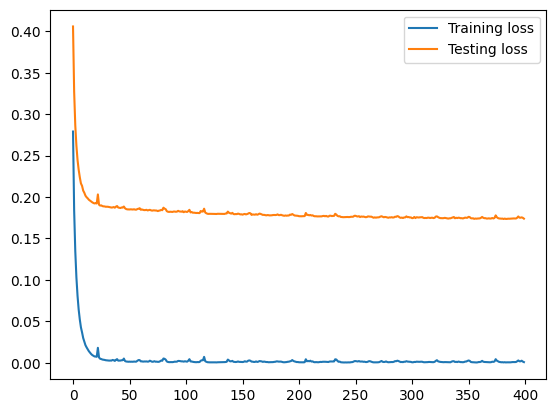

In [26]:
plt.plot(training_loss, label = 'Training loss')
plt.plot(testing_loss, label = 'Testing loss')
plt.legend(loc = 'upper right')
plt.show()

In [27]:
empirical_FC = NPI.corrcoef(np.vstack(signals))
model_FC = NPI.model_FC(ANN, node_num = ROI_num, steps = using_steps)

In [28]:
NPI_EC = NPI.model_EC(ANN, input_X, target_Y, pert_strength=1.0)
np.fill_diagonal(NPI_EC, 0)

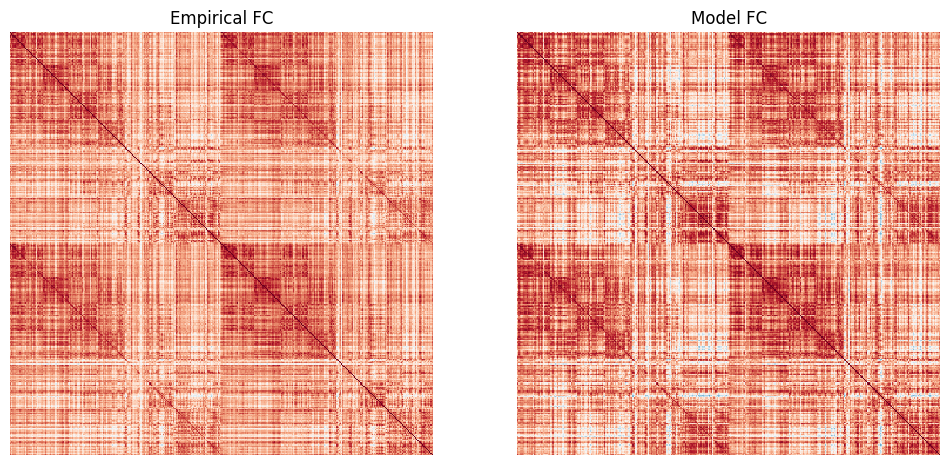

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(empirical_FC[neworder].T[neworder].T, ax = ax1, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(model_FC[neworder].T[neworder].T, ax = ax2, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Empirical FC'); ax2.set_title('Model FC')
plt.show()

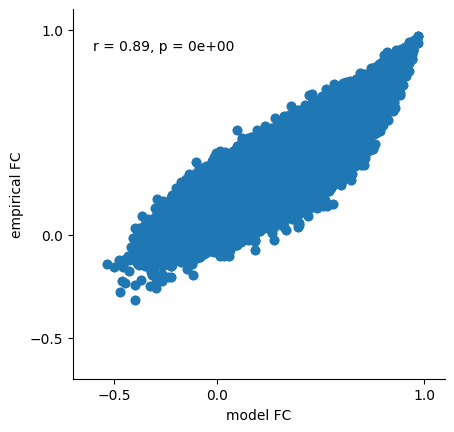

In [30]:
r_value, p_value = pearsonr(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.xlim(-0.7, 1.1); plt.xticks([-0.5, 0.0, 1.0]); plt.xlabel('model FC')
plt.ylim(-0.7, 1.1); plt.yticks([-0.5, 0.0, 1.0]); plt.ylabel('empirical FC')
plt.text(-0.6, 0.9, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()


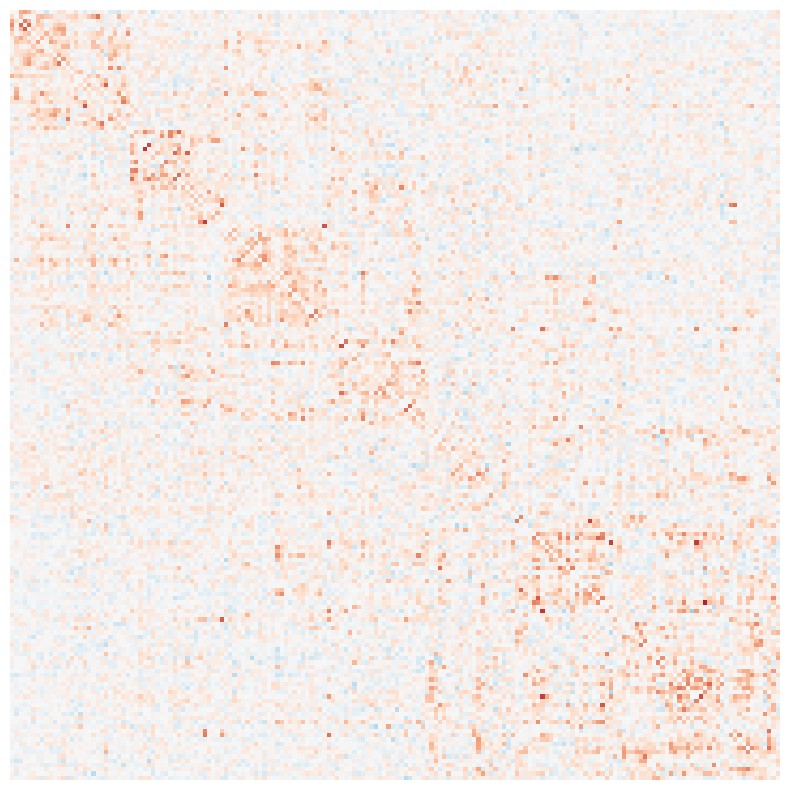

In [32]:
fig = plt.figure(figsize = (10, 10))
sns.heatmap(NPI_EC[neworder].T[neworder].T[:180, :180], vmin = -0.1, vmax = 0.1, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
plt.show()

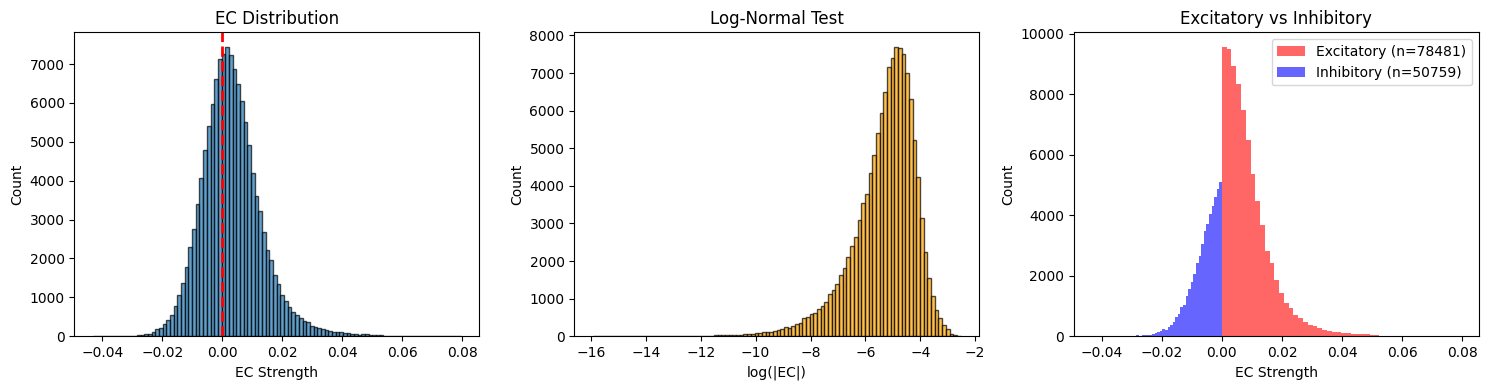

Max excitatory: 0.0795
Max inhibitory: 0.0431
Exc/Inh ratio: 0.5428


In [33]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
EC_flat = NPI_EC[NPI_EC != 0]
plt.hist(EC_flat, bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('EC Strength')
plt.ylabel('Count')
plt.title('EC Distribution')
plt.axvline(0, color='red', linestyle='--', linewidth=2)

plt.subplot(1, 3, 2)
abs_EC = np.abs(EC_flat)
plt.hist(np.log(abs_EC + 1e-10), bins=100, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('log(|EC|)')
plt.ylabel('Count')
plt.title('Log-Normal Test')

plt.subplot(1, 3, 3)
exc = EC_flat[EC_flat > 0]
inh = EC_flat[EC_flat < 0]
plt.hist(exc, bins=50, alpha=0.6, label=f'Excitatory (n={len(exc)})', color='red')
plt.hist(inh, bins=50, alpha=0.6, label=f'Inhibitory (n={len(inh)})', color='blue')
plt.xlabel('EC Strength')
plt.ylabel('Count')
plt.title('Excitatory vs Inhibitory')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Max excitatory: {exc.max():.4f}")
print(f"Max inhibitory: {abs(inh.min()):.4f}")
print(f"Exc/Inh ratio: {abs(inh.min()) / exc.max():.4f}")

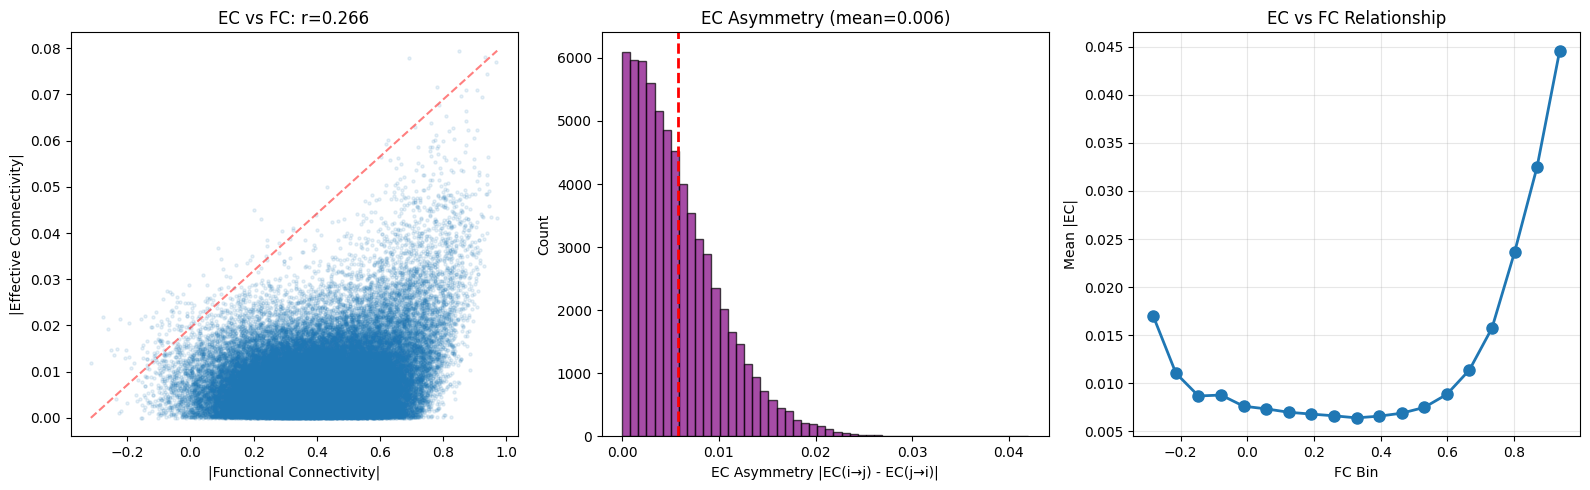

EC-FC correlation: r = 0.2664
Mean EC asymmetry: 0.0058


In [34]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

triu_idx = np.triu_indices_from(empirical_FC, k=1)
fc_flat = empirical_FC[triu_idx]
ec_flat = np.abs(NPI_EC)[triu_idx]

axes[0].scatter(fc_flat, ec_flat, alpha=0.1, s=5)
r_ec_fc = pearsonr(fc_flat, ec_flat)[0]
axes[0].set_xlabel('|Functional Connectivity|')
axes[0].set_ylabel('|Effective Connectivity|')
axes[0].set_title(f'EC vs FC: r={r_ec_fc:.3f}')
axes[0].plot([fc_flat.min(), fc_flat.max()], [ec_flat.min(), ec_flat.max()], 'r--', alpha=0.5)

EC_asym = []
for i in range(NPI_EC.shape[0]):
    for j in range(i+1, NPI_EC.shape[1]):
        EC_asym.append(abs(NPI_EC[i,j] - NPI_EC[j,i]))

axes[1].hist(EC_asym, bins=50, alpha=0.7, edgecolor='black', color='purple')
axes[1].set_xlabel('EC Asymmetry |EC(i→j) - EC(j→i)|')
axes[1].set_ylabel('Count')
axes[1].set_title(f'EC Asymmetry (mean={np.mean(EC_asym):.3f})')
axes[1].axvline(np.mean(EC_asym), color='red', linestyle='--', linewidth=2)

fc_bins = np.linspace(fc_flat.min(), fc_flat.max(), 20)
fc_digitized = np.digitize(fc_flat, fc_bins)
ec_means = [ec_flat[fc_digitized == i].mean() for i in range(1, len(fc_bins))]
fc_centers = (fc_bins[:-1] + fc_bins[1:]) / 2

axes[2].plot(fc_centers, ec_means, 'o-', linewidth=2, markersize=8)
axes[2].set_xlabel('FC Bin')
axes[2].set_ylabel('Mean |EC|')
axes[2].set_title('EC vs FC Relationship')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"EC-FC correlation: r = {r_ec_fc:.4f}")
print(f"Mean EC asymmetry: {np.mean(EC_asym):.4f}")